In [46]:
import heapq
import random

import folium
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from shapely.geometry import MultiLineString
from tqdm.notebook import tqdm

In [2]:
MIN_GRADIENT = 0.08               # minimum average gradient (e.g., 5%)
MIN_LENGTH = 2000                 # ninimum length of the route (in meters)
MAX_DEPTH = 500                   # maximum depth for search (BFS) to avoid excessive computation
MAX_FLAT_SECTION_LENGTH = 50      # maximum length of sections below gradient threshold (in meters)
MIN_SECTION_GRADIENT = 0.03       # minimum gradient for each section (e.g., 3%)

In [3]:
def find_candidate_routes(graph, min_gradient, min_length, max_depth):
    candidate_routes = []

    # using a priority queue to prioritize paths with longer lengths
    queue = []
    for start_node in tqdm(graph.nodes, desc="Initializing Queue"):
        heapq.heappush(queue, (-0, start_node, [start_node], 0, 0, 0))  # (negative length, current_node, path, length, elevation_gain, flat_section_length)
    
    while queue:
        neg_length, current_node, path, length, elevation_gain, flat_section_length = heapq.heappop(queue)
        current_depth = len(path)

        if current_depth > max_depth:
            continue

        for neighbor in graph.neighbors(current_node):
            if neighbor in path:
                continue

            edge_data = graph.get_edge_data(current_node, neighbor, 0)
            edge_length = edge_data.get('length', 0)
            edge_gradient = edge_data.get('grade', 0)

            elevation_diff = edge_length * edge_gradient  # calculated elevation gain (can be negative)

            new_length = length + edge_length
            new_elevation_gain = elevation_gain + elevation_diff
            new_avg_gradient = new_elevation_gain / new_length if new_length > 0 else 0

            # update flat/downhill section length if edge gradient is below MIN_SECTION_GRADIENT
            if edge_gradient >= MIN_SECTION_GRADIENT:
                new_flat_section_length = 0
            else:
                new_flat_section_length = flat_section_length + edge_length

            if new_flat_section_length > MAX_FLAT_SECTION_LENGTH:
                continue  # exceeds allowed length of flat/downhill sections

            new_path = path + [neighbor]

            # add path to candidate_routes if it meets constraints
            if new_length >= min_length and new_avg_gradient >= min_gradient:
                candidate_routes.append((new_path, new_length, new_avg_gradient))

            # continue expanding the path, prioritizing by negative length to maximize route length
            heapq.heappush(queue, (-(new_length), neighbor, new_path, new_length, new_elevation_gain, new_flat_section_length))

    return candidate_routes


def assign_routes(candidate_routes):
    # sort routes by length (longest first)
    candidate_routes.sort(key=lambda x: x[1], reverse=True)

    assigned_routes = []
    used_edges = set()

    for path, length, avg_gradient in candidate_routes:
        # check if any edge in the path has already been used
        route_edges = [(u, v) for u, v in zip(path[:-1], path[1:])]
        if any(edge in used_edges or (edge[1], edge[0]) in used_edges for edge in route_edges):
            continue  # skip this route as it overlaps with an assigned route

        # assign the route and mark its edges as used
        assigned_routes.append((path, length, avg_gradient))
        for edge in route_edges:
            used_edges.add(edge)
            used_edges.add((edge[1], edge[0]))  # add both directions if the graph is undirected

    return assigned_routes

In [4]:
# load graph from file
graph = ox.load_graphml("../data/places/asheville.graphml")

In [5]:
# find all candidate routes
candidate_routes = find_candidate_routes(graph, MIN_GRADIENT, MIN_LENGTH, MAX_DEPTH)
print(f"Found {len(candidate_routes)} candidate routes.")

Initializing Queue:   0%|          | 0/24635 [00:00<?, ?it/s]

Found 1578 candidate routes.


In [6]:
# dedupe routes (assign edges to the longest routes first)
assigned_routes = assign_routes(candidate_routes)
print(f"Assigned {len(assigned_routes)} routes after removing overlaps.")

Assigned 7 routes after removing overlaps.


In [7]:
# print route information
for idx, (path, length, gradient) in enumerate(assigned_routes):
    street_names = set()
    for u, v in zip(path[:-1], path[1:]):
        edge_data = graph.get_edge_data(u, v, 0)
        street_name = edge_data.get('name', 'Unnamed Street')
        street_names.add(street_name)
    print(f"Route {idx + 1}: Length = {length:.1f} m, Avg Gradient = {gradient:.2%}, Streets = {', '.join(street_names)}\n")

Route 1: Length = 3510.9 m, Avg Gradient = 8.01%, Streets = Unnamed Street, Sunset Summit, Westhaven Drive, Charlotte Street, Town Mountain Road, Cherokee Road, Blue Briar Road

Route 2: Length = 3339.6 m, Avg Gradient = 10.39%, Streets = Spivey Mountain Road, Cowan Cove Road

Route 3: Length = 3143.0 m, Avg Gradient = 9.52%, Streets = Unnamed Street, North Merrimon Avenue, Senator Reynolds Road, Windsor Road, Altamont View

Route 4: Length = 2970.7 m, Avg Gradient = 8.39%, Streets = Lynn Cove Road, Unnamed Street

Route 5: Length = 2699.2 m, Avg Gradient = 8.18%, Streets = Upper Herron Cove Road, Unnamed Street, Elk Mountain Scenic Highway, Elk Ridge Drive

Route 6: Length = 2370.3 m, Avg Gradient = 8.94%, Streets = Baird Cove Road, Unnamed Street, Versant Drive, Ventana Drive

Route 7: Length = 2018.8 m, Avg Gradient = 8.13%, Streets = Unnamed Street, Charlotte Street, Town Mountain Road, Westview Road, Oak Park Road, Clayton Street, Arlington Street, Furman Avenue



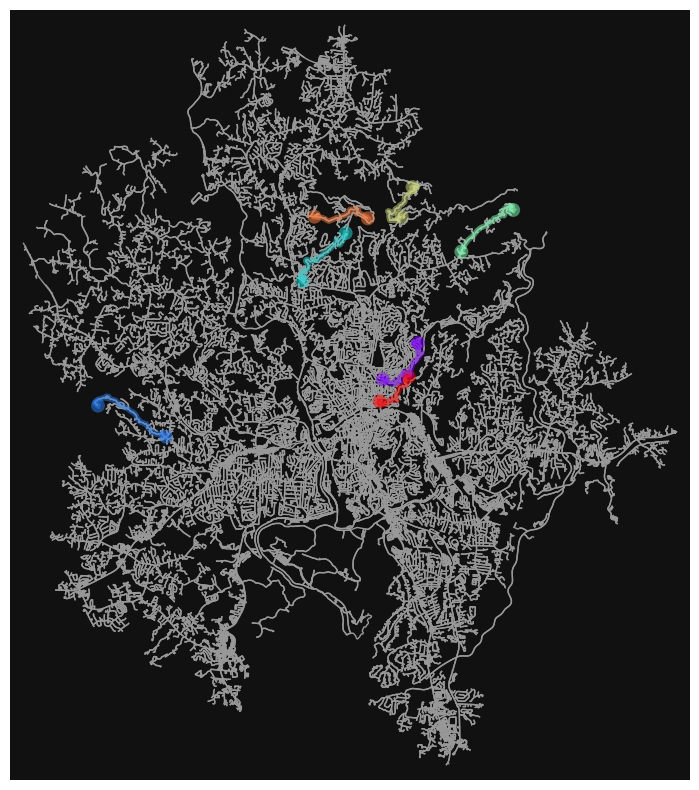

In [36]:
# visualize routes

# extract routes from assigned_routes
routes = [path for path, _, _ in assigned_routes]

# generate a color map for the routes
cmap = plt.get_cmap('rainbow', len(routes))
route_colors = [mcolors.rgb2hex(cmap(i)) for i in range(len(routes))]

# plot the graph with the routes
fig, ax = ox.plot_graph_routes(
    graph,
    routes,
    route_colors=route_colors,
    route_linewidth=3,
    node_size=0,
    show=False,
    close=False
)

# save and display plot
fig.set_size_inches(10, 10)
plt.savefig("../data/results/asheville-climbs.png", dpi=300)
plt.show()

In [47]:
# export results to an html w/ an interactive map

# create folium map
nodes = ox.graph_to_gdfs(graph, edges=False)
center_lat = nodes.geometry.y.mean()
center_lon = nodes.geometry.x.mean()
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=13,
    tiles='cartodbpositron'
)

# collect all route geometries to compute the bounding box
route_geometries = []

# add the routes to the map
for idx, (path, length, avg_gradient) in enumerate(assigned_routes):
    # get the edges for the route
    route_edges = [(u, v, 0) for u, v in zip(path[:-1], path[1:])]
    # create a subgraph for the route
    route_graph = graph.edge_subgraph(route_edges)
    # get the geometry of the route
    route_gdf = ox.graph_to_gdfs(route_graph, nodes=False, fill_edge_geometry=True)
    # ensure the geometry is in lat/lon
    if route_gdf.crs != 'EPSG:4326':
        route_gdf = route_gdf.to_crs(epsg=4326)
    # collect geometries
    route_geometries.extend(route_gdf.geometry)
    # convert the geometry to geojson
    geojson_data = route_gdf.to_json()
    # generate a random color for the route
    color = "#{:06x}".format(random.randint(0, 0xFFFFFF))
    # add the route to the map
    folium.GeoJson(
        geojson_data,
        name=f"Route {idx+1}",
        style_function=lambda feature, color=color: { 'color': color, 'weight': 5, 'opacity': 0.6 },
        tooltip=folium.Tooltip(f"Route {idx+1}: Length {length:.1f} m, Avg Gradient {avg_gradient:.2%}")
    ).add_to(m)

# compute the total bounding box of all routes
all_routes_geometry = MultiLineString(route_geometries)
min_lon, min_lat, max_lon, max_lat = all_routes_geometry.bounds

# fit the map to the bounds
m.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])

# save map to an html file
m.save("../data/results/asheville-climbs.html")